In [0]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FINAL-TF2-FILES/TF_2_Notebooks_and_Data/DATA/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [0]:
df.columns = ['Sales']

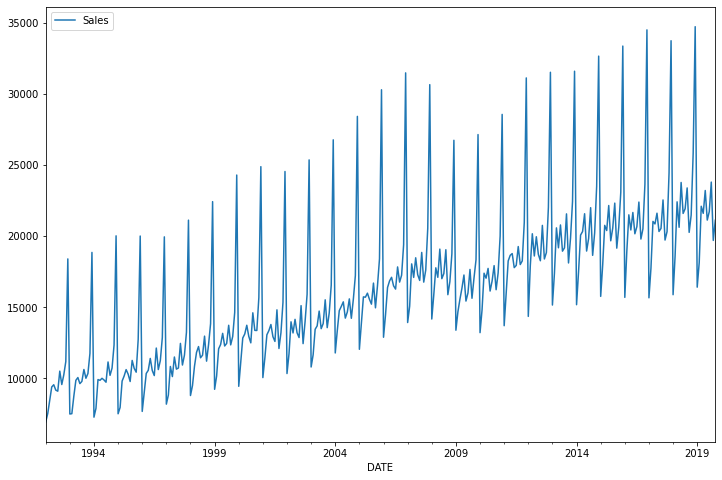

In [6]:
df.plot(figsize=(12,8))

In [7]:
len(df)

334

In [8]:
len(df)- 18

316

In [0]:
test_size = 12

In [0]:
test_ind = len(df)- test_size

In [0]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381


In [13]:
test

,Sales
DATE,
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410
2019-02-01,18134
2019-03-01,22093
2019-04-01,21597
2019-05-01,23200
2019-06-01,21123
2019-07-01,21714


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [16]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=2)

In [0]:
# What does the first batch look like?
X,y = generator[0]

In [21]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266
 0.02127505 0.05580163 0.08942056 0.09512053 0.08146965 0.07860151
 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266 0.02047633]
Predict this y: 
 [[0.02047633]
 [0.02127505]]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [0]:
# We're only using one feature in our time series
n_features = 1

In [29]:
# define model
neuron_performance = []
for n in range (1,251):
  n_neurons = n
  model = Sequential()
  model.add(LSTM(n_neurons, activation='relu', input_shape=(length, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit_generator(generator,epochs=6,
                      validation_data=validation_generator,
                      callbacks=early_stop)
  test_predictions = []

  first_eval_batch = scaled_train[-length:]
  current_batch = first_eval_batch.reshape((1, length, n_features))

  for i in range(len(test)):
    
      # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
      current_pred = model.predict(current_batch)[0]
    
      # store prediction
      test_predictions.append(current_pred) 
    
      # update batch to now include prediction and drop first value
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
  true_predictions = scaler.inverse_transform(test_predictions)
  try: 
    test = test.drop('Predictions',axis=1)
    test['Predictions'] = true_predictions
  except:
    test['Predictions'] = true_predictions
  performance = np.sqrt(mean_squared_error(test["Sales"],test["Predictions"]))
  neuron_performance.append(performance)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/6
155/155 [==============================] - 1s 6ms/step - loss: 0.0418 - val_loss: 0.0141
Epoch 2/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0268 - val_loss: 0.0063
Epoch 3/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0249 - val_loss: 0.0035
Epoch 4/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0240 - val_loss: 0.0042
Epoch 5/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0025
Epoch 6/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0227 - val_loss: 0.0028


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/6
155/155 [==============================] - 1s 5ms/step - loss: 0.1175 - val_loss: 0.1521
Epoch 2/6
155/155 [==============================] - 1s 4ms/step - loss: 0.0636 - val_loss: 0.0878
Epoch 3/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0450 - val_loss: 0.0589
Epoch 4/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0384 - val_loss: 0.0435
Epoch 5/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0363 - val_loss: 0.0365
Epoch 6/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0358 - val_loss: 0.0346
Epoch 1/6
155/155 [==============================] - 1s 6ms/step - loss: 0.2549 - val_loss: 0.2810
Epoch 2/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0940 - val_loss: 0.1373
Epoch 3/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0556 - val_loss: 0.0807
Epoch 4/6
155/155 [==============================] - 1s 5ms/step - loss: 0.0427 - val_loss: 0.0545
Epoch 5/6


In [0]:
nn = pd.DataFrame(neuron_performance)

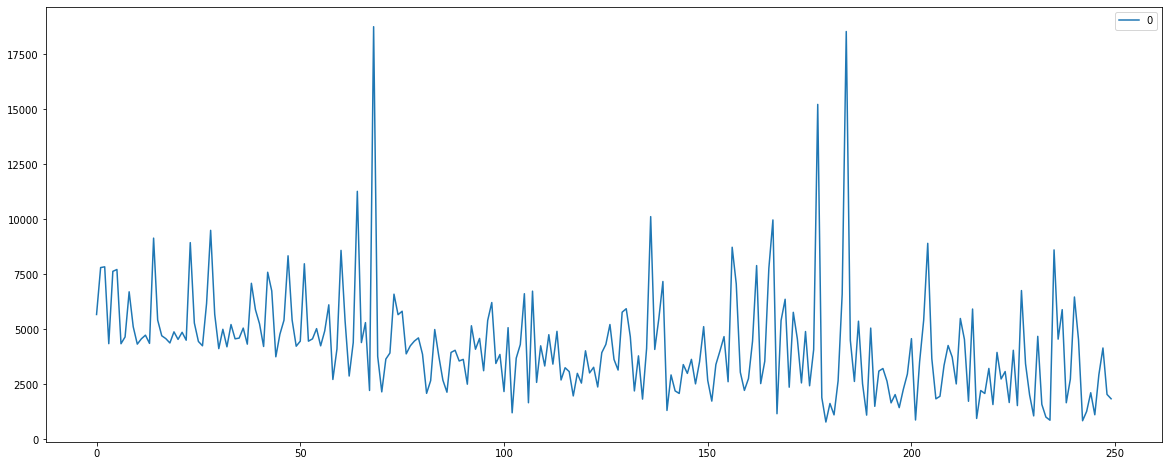

In [58]:
nn.plot(figsize=(20,8))

In [0]:
nn.columns=['prediction']

In [60]:
nn

,prediction
0,5677.177884
1,7809.122109
2,7843.621662
3,4351.775593
4,7637.303753
...,...
245,1122.297914
246,2941.039129
247,4155.896702
248,2047.146492


In [0]:
nn = nn.sort_values('prediction')

In [0]:
nn = nn.head(5)

In [0]:
neuron_number = nn['prediction'].index.values.astype('int')

In [68]:
# define model
neuron_performance = []
for n in neuron_number:
  n_neurons = n
  model = Sequential()
  model.add(LSTM(n_neurons, activation='relu', input_shape=(length, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit_generator(generator,epochs=6,
                      validation_data=validation_generator,
                      callbacks=early_stop)
  test_predictions = []

  first_eval_batch = scaled_train[-length:]
  current_batch = first_eval_batch.reshape((1, length, n_features))

  for i in range(len(test)):
    
      # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
      current_pred = model.predict(current_batch)[0]
    
      # store prediction
      test_predictions.append(current_pred) 
    
      # update batch to now include prediction and drop first value
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
  true_predictions = scaler.inverse_transform(test_predictions)
  try: 
    test = test.drop('Predictions',axis=1)
    test['Predictions'] = true_predictions
  except:
    test['Predictions'] = true_predictions
  performance = np.sqrt(mean_squared_error(test["Sales"],test["Predictions"]))
  neuron_performance.append(performance)

Epoch 1/6
155/155 [==============================] - 2s 14ms/step - loss: 0.0258 - val_loss: 0.0057
Epoch 2/6
155/155 [==============================] - 2s 12ms/step - loss: 0.0167 - val_loss: 0.0448
Epoch 3/6
155/155 [==============================] - 2s 12ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 1/6
155/155 [==============================] - 3s 19ms/step - loss: 0.0266 - val_loss: 0.0041
Epoch 2/6
155/155 [==============================] - 3s 18ms/step - loss: 0.0201 - val_loss: 0.0034
Epoch 3/6
155/155 [==============================] - 3s 18ms/step - loss: 0.0096 - val_loss: 0.0091
Epoch 4/6
155/155 [==============================] - 3s 18ms/step - loss: 0.0054 - val_loss: 0.0524
Epoch 1/6
155/155 [==============================] - 3s 18ms/step - loss: 0.0268 - val_loss: 1.1752e-04
Epoch 2/6
155/155 [==============================] - 3s 16ms/step - loss: 0.0183 - val_loss: 0.0025
Epoch 3/6
155/155 [==============================] - 3s 17ms/step - loss: 0.0139 - val_loss: 0.0

In [0]:
nn = pd.DataFrame(neuron_performance)

In [0]:
nn = nn.sort_values('prediction')

In [0]:
nn = nn.head(1)

In [0]:
best_neuron = nn.index.values.astype(int)

In [0]:
final= neuron_number[best_neuron]

In [99]:
model.summary()

Model: "sequential_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_256 (LSTM)              (None, 216)               188352    
_________________________________________________________________
dense_256 (Dense)            (None, 1)                 217       
Total params: 188,569
Trainable params: 188,569
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [0]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length-1, batch_size=2)

In [157]:
# fit model
model = Sequential()
model.add(LSTM(final[0], activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/6
161/161 [==============================] - 3s 17ms/step - loss: 0.0248 - val_loss: 2.9802e-04
Epoch 2/6
161/161 [==============================] - 3s 16ms/step - loss: 0.0139 - val_loss: 0.0333
Epoch 3/6
161/161 [==============================] - 3s 16ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 4/6
161/161 [==============================] - 3s 16ms/step - loss: 0.0057 - val_loss: 0.0172


In [0]:

losses = pd.DataFrame(model.history.history)

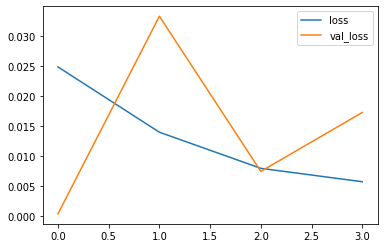

In [159]:
losses.plot()

In [0]:
n_input = 12

In [0]:
first_eval_batch = scaled_train[-length:]

In [0]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [163]:
model.predict(first_eval_batch)

array([[0.6299131]], dtype=float32)

In [164]:
scaled_test[0]

array([0.68592071])

In [0]:
import numpy as np
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [0]:
true_predictions = scaler.inverse_transform(test_predictions)

In [0]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [168]:
test

,Sales,Predictions
DATE,,
2018-11-01,25831,24288.326197
2018-12-01,34706,34534.801974
2019-01-01,16410,16716.012991
2019-02-01,18134,18319.902101
2019-03-01,22093,21344.582474
2019-04-01,21597,19790.016469
2019-05-01,23200,22542.191733
2019-06-01,21123,20594.166305
2019-07-01,21714,20859.573306


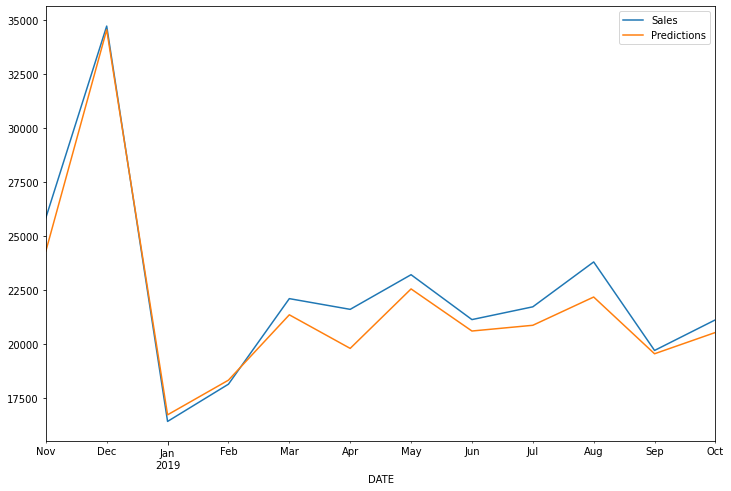

In [169]:
test.plot(figsize=(12,8))

In [0]:
from sklearn.metrics import mean_squared_error

In [171]:
np.sqrt(mean_squared_error(test["Sales"],test["Predictions"]))

948.9988080598255

In [0]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [0]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=2)

In [147]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0318
Epoch 2/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0202
Epoch 3/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0164
Epoch 4/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0094
Epoch 5/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0064
Epoch 6/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 7/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0016
Epoch 8/8
161/161 [==============================] - 1s 9ms/step - loss: 0.0016


In [0]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [0]:
forecast = scaler.inverse_transform(forecast)

In [150]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [0]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [0]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [153]:
forecast_df

,Forecast
2019-11-01,26640.151612
2019-12-01,37967.324324
2020-01-01,17341.641358
2020-02-01,18652.262964
2020-03-01,22419.135978
2020-04-01,21933.713089
2020-05-01,23584.913340
2020-06-01,21573.476947
2020-07-01,22189.269588
2020-08-01,24299.486815


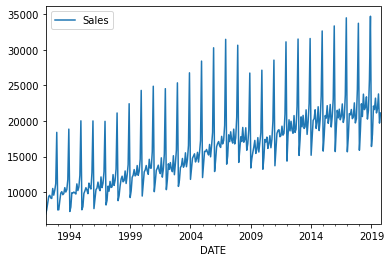

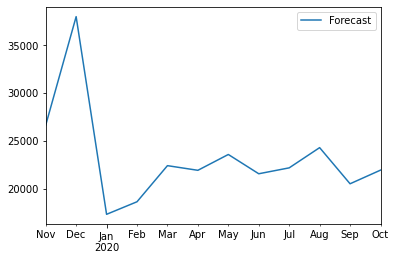

In [154]:
df.plot()
forecast_df.plot()

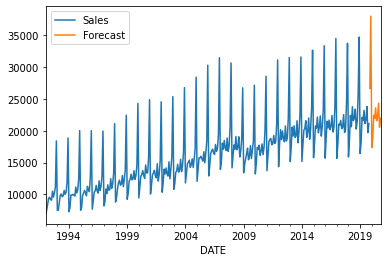

In [155]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

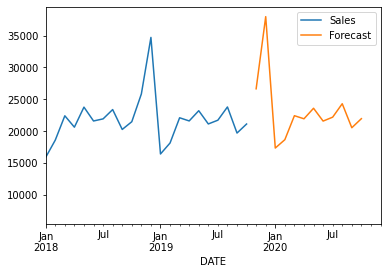

In [156]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')